# 🔍 Analyse du Data Drift

Ce notebook analyse la dérive des données entre l'entraînement et la production.

## Objectifs
1. Comparer les distributions des features
2. Détecter les drifts statistiques
3. Visualiser les changements
4. Recommandations pour le re-entraînement

In [13]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from scipy import stats
import warnings
import math
warnings.filterwarnings('ignore')

# Configuration des graphiques
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

## 1. Chargement des données

In [14]:
# Charger les données de référence (entraînement)
reference_df = pd.read_csv('../output/dataset_train_top40.csv')
print(f"📊 Données de référence: {len(reference_df)} échantillons")
print(f"Colonnes: {reference_df.columns.tolist()}")
reference_df.head()

📊 Données de référence: 307507 échantillons
Colonnes: ['ACTIVE_DAYS_CREDIT_ENDDATE_MIN', 'ACTIVE_DAYS_CREDIT_MAX', 'ACTIVE_DAYS_CREDIT_MEAN', 'ACTIVE_DAYS_CREDIT_UPDATE_MEAN', 'AMT_ANNUITY', 'AMT_CREDIT', 'AMT_GOODS_PRICE', 'ANNUITY_INCOME_PERC', 'APPROVED_APP_CREDIT_PERC_VAR', 'APPROVED_DAYS_DECISION_MAX', 'BURO_AMT_CREDIT_SUM_MEAN', 'BURO_DAYS_CREDIT_VAR', 'CLOSED_DAYS_CREDIT_MAX', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_EMPLOYED_PERC', 'DAYS_ID_PUBLISH', 'DAYS_LAST_PHONE_CHANGE', 'DAYS_REGISTRATION', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'INCOME_CREDIT_PERC', 'INCOME_PER_PERSON', 'INSTAL_AMT_PAYMENT_MAX', 'INSTAL_AMT_PAYMENT_MIN', 'INSTAL_DAYS_ENTRY_PAYMENT_MAX', 'INSTAL_DAYS_ENTRY_PAYMENT_SUM', 'INSTAL_DBD_MAX', 'INSTAL_DBD_MEAN', 'INSTAL_DBD_SUM', 'PAYMENT_RATE', 'POS_MONTHS_BALANCE_MEAN', 'POS_NAME_CONTRACT_STATUS_Active_MEAN', 'POS_NAME_CONTRACT_STATUS_Completed_MEAN', 'PREV_APP_CREDIT_PERC_MEAN', 'PREV_APP_CREDIT_PERC_VAR', 'PREV_DAYS_DECISION_MAX', 'PREV_HOUR_APPR_PROCE

,ACTIVE_DAYS_CREDIT_ENDDATE_MIN,ACTIVE_DAYS_CREDIT_MAX,ACTIVE_DAYS_CREDIT_MEAN,ACTIVE_DAYS_CREDIT_UPDATE_MEAN,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,ANNUITY_INCOME_PERC,APPROVED_APP_CREDIT_PERC_VAR,APPROVED_DAYS_DECISION_MAX,...,POS_MONTHS_BALANCE_MEAN,POS_NAME_CONTRACT_STATUS_Active_MEAN,POS_NAME_CONTRACT_STATUS_Completed_MEAN,PREV_APP_CREDIT_PERC_MEAN,PREV_APP_CREDIT_PERC_VAR,PREV_DAYS_DECISION_MAX,PREV_HOUR_APPR_PROCESS_START_MEAN,REGION_POPULATION_RELATIVE,TARGET,SK_ID_CURR
0,780.0,-103.0,-572.5,-15.5,24700.5,406597.5,351000.0,0.121978,NaN,-606.0,...,-10.000000,1.000000,0.000000,1.000000,NaN,-606.0,9.000000,0.018801,1.0,100002
1,1216.0,-606.0,-606.0,-43.0,35698.5,1293502.5,1129500.0,0.132217,0.005324,-746.0,...,-43.785714,0.928571,0.071429,0.949329,0.005324,-746.0,14.666667,0.003541,0.0,100003
2,NaN,NaN,NaN,NaN,6750.0,135000.0,135000.0,0.100000,NaN,-815.0,...,-25.500000,0.750000,0.250000,1.207699,NaN,-815.0,5.000000,0.010032,0.0,100004
3,NaN,NaN,NaN,NaN,29686.5,312682.5,297000.0,0.219900,0.014849,-181.0,...,-9.619048,0.857143,0.095238,1.010763,0.027041,-181.0,14.666667,0.008019,0.0,100006
4,NaN,NaN,NaN,NaN,21865.5,513000.0,513000.0,0.179963,0.016456,-374.0,...,-33.636364,0.939394,0.045455,0.969650,0.016456,-374.0,12.333333,0.028663,0.0,100007


In [15]:
# Charger les logs de production
production_logs = []
with open('../logs/production_logs.json', 'r') as f:
    for line in f:
        if line.strip():
            production_logs.append(json.loads(line))

production_df = pd.DataFrame(production_logs)
input_df = pd.json_normalize(production_df['input'])

print(f"📊 Données de production: {len(input_df)} échantillons")
print(f"Colonnes: {input_df.columns.tolist()}")
input_df.head()

📊 Données de production: 1951 échantillons
Colonnes: ['ACTIVE_DAYS_CREDIT_ENDDATE_MIN', 'ACTIVE_DAYS_CREDIT_MAX', 'ACTIVE_DAYS_CREDIT_MEAN', 'ACTIVE_DAYS_CREDIT_UPDATE_MEAN', 'AMT_ANNUITY', 'AMT_CREDIT', 'AMT_GOODS_PRICE', 'ANNUITY_INCOME_PERC', 'APPROVED_APP_CREDIT_PERC_VAR', 'APPROVED_DAYS_DECISION_MAX', 'BURO_AMT_CREDIT_SUM_MEAN', 'BURO_DAYS_CREDIT_VAR', 'CLOSED_DAYS_CREDIT_MAX', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_EMPLOYED_PERC', 'DAYS_ID_PUBLISH', 'DAYS_LAST_PHONE_CHANGE', 'DAYS_REGISTRATION', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'INCOME_CREDIT_PERC', 'INCOME_PER_PERSON', 'INSTAL_AMT_PAYMENT_MAX', 'INSTAL_AMT_PAYMENT_MIN', 'INSTAL_DAYS_ENTRY_PAYMENT_MAX', 'INSTAL_DAYS_ENTRY_PAYMENT_SUM', 'INSTAL_DBD_MAX', 'INSTAL_DBD_MEAN', 'INSTAL_DBD_SUM', 'PAYMENT_RATE', 'POS_MONTHS_BALANCE_MEAN', 'POS_NAME_CONTRACT_STATUS_Active_MEAN', 'POS_NAME_CONTRACT_STATUS_Completed_MEAN', 'PREV_APP_CREDIT_PERC_MEAN', 'PREV_APP_CREDIT_PERC_VAR', 'PREV_DAYS_DECISION_MAX', 'PREV_HOUR_APPR_PROCES

,ACTIVE_DAYS_CREDIT_ENDDATE_MIN,ACTIVE_DAYS_CREDIT_MAX,ACTIVE_DAYS_CREDIT_MEAN,ACTIVE_DAYS_CREDIT_UPDATE_MEAN,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,ANNUITY_INCOME_PERC,APPROVED_APP_CREDIT_PERC_VAR,APPROVED_DAYS_DECISION_MAX,...,INSTAL_DBD_SUM,PAYMENT_RATE,POS_MONTHS_BALANCE_MEAN,POS_NAME_CONTRACT_STATUS_Active_MEAN,POS_NAME_CONTRACT_STATUS_Completed_MEAN,PREV_APP_CREDIT_PERC_MEAN,PREV_APP_CREDIT_PERC_VAR,PREV_DAYS_DECISION_MAX,PREV_HOUR_APPR_PROCESS_START_MEAN,REGION_POPULATION_RELATIVE
0,350.0,-17.0,-17.0,-17.0,21000.0,296000.0,225000.0,0.12,0.01,-320.0,...,170.0,0.07,-6.0,0.9,0.09,0.93,0.01,-320.0,20.0,0.03
1,350.0,-17.0,-17.0,-17.0,21000.0,296000.0,225000.0,0.12,0.01,-320.0,...,170.0,0.07,-6.0,0.9,0.09,0.93,0.01,-320.0,20.0,0.03
2,350.0,-17.0,-17.0,-17.0,21000.0,296000.0,225000.0,0.12,0.01,-320.0,...,170.0,0.07,-6.0,0.9,0.09,0.93,0.01,-320.0,20.0,0.03
3,350.0,-17.0,-17.0,-17.0,21000.0,296000.0,225000.0,0.12,0.01,-320.0,...,170.0,0.07,-6.0,0.9,0.09,0.93,0.01,-320.0,20.0,0.03
4,350.0,-17.0,-17.0,-17.0,21000.0,296000.0,225000.0,0.12,0.01,-320.0,...,170.0,0.07,-6.0,0.9,0.09,0.93,0.01,-320.0,20.0,0.03


## 2. Statistiques descriptives

In [16]:
# Comparaison des statistiques
features = [
    'ACTIVE_DAYS_CREDIT_ENDDATE_MIN',
    'ACTIVE_DAYS_CREDIT_MAX',
    'ACTIVE_DAYS_CREDIT_MEAN',
    'ACTIVE_DAYS_CREDIT_UPDATE_MEAN',
    'AMT_ANNUITY',
    'AMT_CREDIT',
    'AMT_GOODS_PRICE',
    'ANNUITY_INCOME_PERC',
    'APPROVED_APP_CREDIT_PERC_VAR',
    'APPROVED_DAYS_DECISION_MAX',
    'BURO_AMT_CREDIT_SUM_MEAN',
    'BURO_DAYS_CREDIT_VAR',
    'CLOSED_DAYS_CREDIT_MAX',
    'DAYS_BIRTH',
    'DAYS_EMPLOYED',
    'DAYS_EMPLOYED_PERC',
    'DAYS_ID_PUBLISH',
    'DAYS_LAST_PHONE_CHANGE',
    'DAYS_REGISTRATION',
    'EXT_SOURCE_1',
    'EXT_SOURCE_2',
    'EXT_SOURCE_3',
    'INCOME_CREDIT_PERC',
    'INCOME_PER_PERSON',
    'INSTAL_AMT_PAYMENT_MAX',
    'INSTAL_AMT_PAYMENT_MIN',
    'INSTAL_DAYS_ENTRY_PAYMENT_MAX',
    'INSTAL_DAYS_ENTRY_PAYMENT_SUM',
    'INSTAL_DBD_MAX',
    'INSTAL_DBD_MEAN',
    'INSTAL_DBD_SUM',
    'PAYMENT_RATE',
    'POS_MONTHS_BALANCE_MEAN',
    'POS_NAME_CONTRACT_STATUS_Active_MEAN',
    'POS_NAME_CONTRACT_STATUS_Completed_MEAN',
    'PREV_APP_CREDIT_PERC_MEAN',
    'PREV_APP_CREDIT_PERC_VAR',
    'PREV_DAYS_DECISION_MAX',
    'PREV_HOUR_APPR_PROCESS_START_MEAN',
    'REGION_POPULATION_RELATIVE'
]

print("\n📊 STATISTIQUES DESCRIPTIVES\n")
print("=" * 80)

for feature in features:
    if feature in reference_df.columns and feature in input_df.columns:
        print(f"\n{feature.upper()}:")
        print(f"  Référence - Moyenne: {reference_df[feature].mean():.2f}, Std: {reference_df[feature].std():.2f}")
        print(f"  Production - Moyenne: {input_df[feature].mean():.2f}, Std: {input_df[feature].std():.2f}")
        
        # Différence en %
        diff = ((input_df[feature].mean() - reference_df[feature].mean()) / reference_df[feature].mean() * 100)
        print(f"  Différence: {diff:+.2f}%")


📊 STATISTIQUES DESCRIPTIVES


ACTIVE_DAYS_CREDIT_ENDDATE_MIN:
  Référence - Moyenne: 1011.92, Std: 4687.73
  Production - Moyenne: 342.08, Std: 199.29
  Différence: -66.19%

ACTIVE_DAYS_CREDIT_MAX:
  Référence - Moyenne: -416.94, Std: 471.07
  Production - Moyenne: -17.01, Std: 9.79
  Différence: -95.92%

ACTIVE_DAYS_CREDIT_MEAN:
  Référence - Moyenne: -650.79, Std: 495.74
  Production - Moyenne: -18.56, Std: 21.95
  Différence: -97.15%

ACTIVE_DAYS_CREDIT_UPDATE_MEAN:
  Référence - Moyenne: -132.20, Std: 295.45
  Production - Moyenne: -17.17, Std: 9.55
  Différence: -87.01%

AMT_ANNUITY:
  Référence - Moyenne: 27108.67, Std: 14493.80
  Production - Moyenne: 20901.66, Std: 11483.48
  Différence: -22.90%

AMT_CREDIT:
  Référence - Moyenne: 599028.60, Std: 402492.60
  Production - Moyenne: 293261.62, Std: 166435.28
  Différence: -51.04%

AMT_GOODS_PRICE:
  Référence - Moyenne: 538397.72, Std: 369447.25
  Production - Moyenne: 224597.68, Std: 127385.34
  Différence: -58.28%

ANNUITY_INCO

## 3. Tests statistiques de drift

In [17]:
# Test de Kolmogorov-Smirnov pour chaque feature
drift_results = []

print("\n🔍 DÉTECTION DE DRIFT (Test Kolmogorov-Smirnov)\n")
print("=" * 80)

for feature in features:
    if feature in reference_df.columns and feature in input_df.columns:
        # KS test
        ks_stat, p_value = stats.ks_2samp(
            reference_df[feature].dropna(),
            input_df[feature].dropna()
        )
        
        # Interpréter le résultat
        drift_detected = p_value < 0.01
        status = "🔴 DRIFT DÉTECTÉ" if drift_detected else "🟢 OK"
        
        drift_results.append({
            'Feature': feature,
            'KS Statistic': ks_stat,
            'P-Value': p_value,
            'Drift': drift_detected,
            'Status': status
        })
        
        print(f"\n{feature}:")
        print(f"  KS Statistic: {ks_stat:.4f}")
        print(f"  P-Value: {p_value:.4f}")
        print(f"  Status: {status}")

# Créer un DataFrame des résultats
drift_df = pd.DataFrame(drift_results)
drift_df


🔍 DÉTECTION DE DRIFT (Test Kolmogorov-Smirnov)


ACTIVE_DAYS_CREDIT_ENDDATE_MIN:
  KS Statistic: 0.2777
  P-Value: 0.0000
  Status: 🔴 DRIFT DÉTECTÉ

ACTIVE_DAYS_CREDIT_MAX:
  KS Statistic: 0.9493
  P-Value: 0.0000
  Status: 🔴 DRIFT DÉTECTÉ

ACTIVE_DAYS_CREDIT_MEAN:
  KS Statistic: 0.9853
  P-Value: 0.0000
  Status: 🔴 DRIFT DÉTECTÉ

ACTIVE_DAYS_CREDIT_UPDATE_MEAN:
  KS Statistic: 0.4582
  P-Value: 0.0000
  Status: 🔴 DRIFT DÉTECTÉ

AMT_ANNUITY:
  KS Statistic: 0.1509
  P-Value: 0.0000
  Status: 🔴 DRIFT DÉTECTÉ

AMT_CREDIT:
  KS Statistic: 0.4151
  P-Value: 0.0000
  Status: 🔴 DRIFT DÉTECTÉ

AMT_GOODS_PRICE:
  KS Statistic: 0.5659
  P-Value: 0.0000
  Status: 🔴 DRIFT DÉTECTÉ

ANNUITY_INCOME_PERC:
  KS Statistic: 0.2336
  P-Value: 0.0000
  Status: 🔴 DRIFT DÉTECTÉ

APPROVED_APP_CREDIT_PERC_VAR:
  KS Statistic: 0.3662
  P-Value: 0.0000
  Status: 🔴 DRIFT DÉTECTÉ

APPROVED_DAYS_DECISION_MAX:
  KS Statistic: 0.3091
  P-Value: 0.0000
  Status: 🔴 DRIFT DÉTECTÉ

BURO_AMT_CREDIT_SUM_MEAN:
  KS Stati

,Feature,KS Statistic,P-Value,Drift,Status
0,ACTIVE_DAYS_CREDIT_ENDDATE_MIN,0.277717,2.652327e-132,True,🔴 DRIFT DÉTECTÉ
1,ACTIVE_DAYS_CREDIT_MAX,0.949275,0.000000e+00,True,🔴 DRIFT DÉTECTÉ
2,ACTIVE_DAYS_CREDIT_MEAN,0.985283,0.000000e+00,True,🔴 DRIFT DÉTECTÉ
3,ACTIVE_DAYS_CREDIT_UPDATE_MEAN,0.458226,0.000000e+00,True,🔴 DRIFT DÉTECTÉ
4,AMT_ANNUITY,0.150851,5.495179e-39,True,🔴 DRIFT DÉTECTÉ
5,AMT_CREDIT,0.415106,5.308244e-303,True,🔴 DRIFT DÉTECTÉ
6,AMT_GOODS_PRICE,0.565903,0.000000e+00,True,🔴 DRIFT DÉTECTÉ
7,ANNUITY_INCOME_PERC,0.233637,1.447758e-93,True,🔴 DRIFT DÉTECTÉ
8,APPROVED_APP_CREDIT_PERC_VAR,0.366191,6.824115e-233,True,🔴 DRIFT DÉTECTÉ
9,APPROVED_DAYS_DECISION_MAX,0.309086,6.488596e-165,True,🔴 DRIFT DÉTECTÉ


## 4. Visualisations des distributions

ValueError: supplied range of [0.0, inf] is not finite

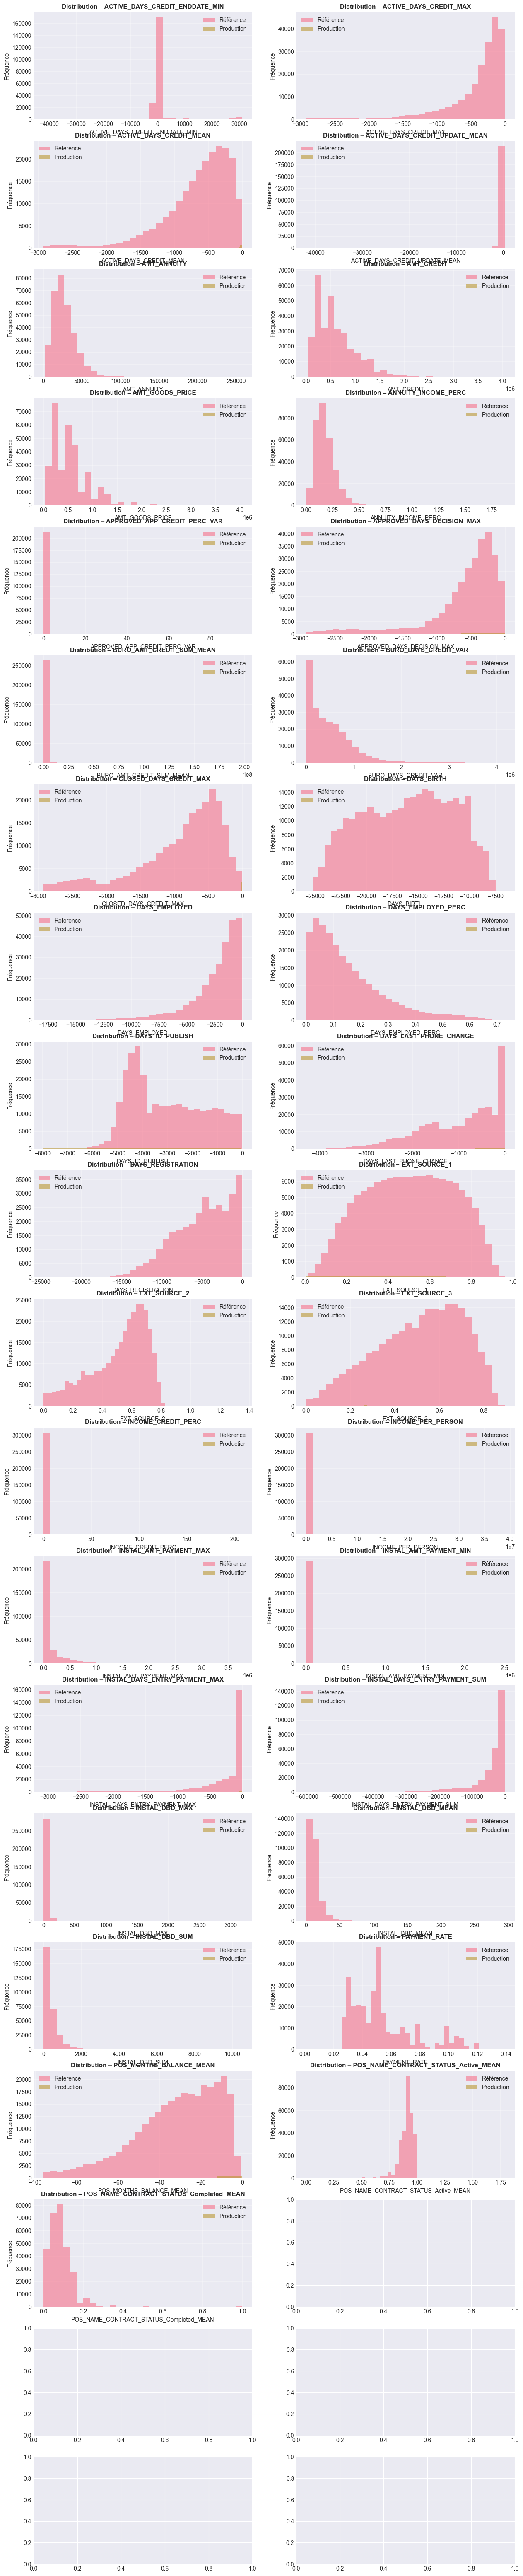

In [18]:
n_features = len(features)
n_cols = 2
n_rows = math.ceil(n_features / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
axes = axes.flatten()

for idx, feature in enumerate(features):
    ax = axes[idx]

    if feature not in reference_df.columns or feature not in input_df.columns:
        ax.set_visible(False)
        continue

    ref_values = reference_df[feature].dropna()
    prod_values = input_df[feature].dropna()

    # Référence = histogramme
    ax.hist(ref_values, bins=30, alpha=0.6, label="Référence")

    # Production = ligne si peu de valeurs
    if len(prod_values) <= 5:
        for v in prod_values:
            ax.axvline(v, linestyle="--", label="Production")
    else:
        ax.hist(prod_values, bins=30, alpha=0.6, label="Production")

    ax.set_title(f"Distribution – {feature}", fontsize=11, fontweight="bold")
    ax.set_xlabel(feature)
    ax.set_ylabel("Fréquence")
    ax.legend()
    ax.grid(True, alpha=0.3)

# Supprimer proprement les axes inutilisés
for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig("../output/drift_analysis_distributions.png", dpi=300)
plt.show()

print("💾 Graphique sauvegardé: drift_analysis_distributions.png")

## 5. Box plots comparatifs

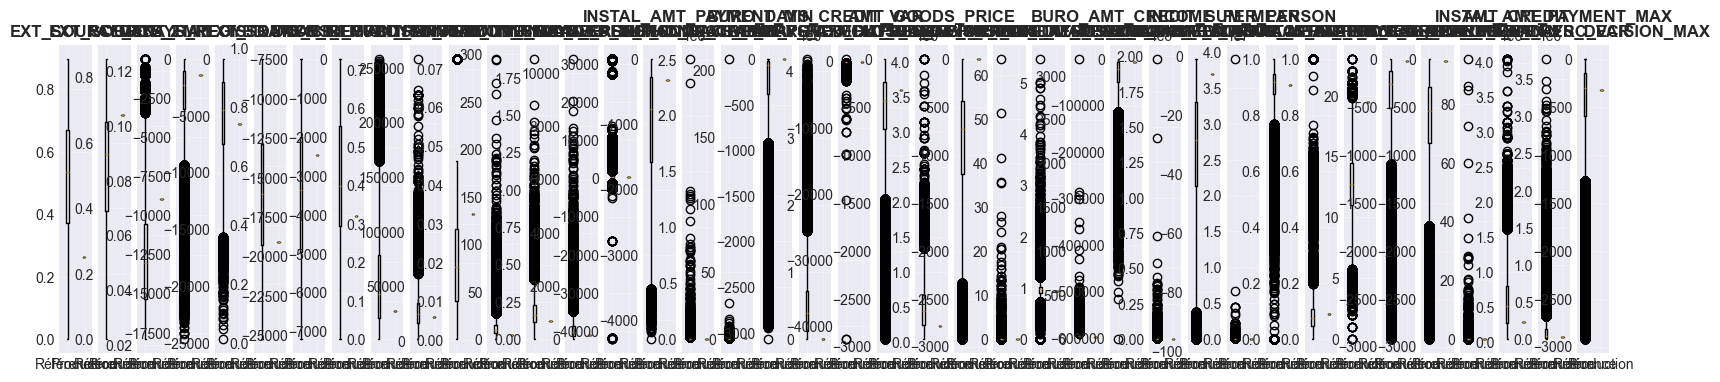


💾 Graphique sauvegardé: drift_analysis_boxplots.png


In [ ]:
# Créer des box plots
fig, axes = plt.subplots(1, len(features), figsize=(20, 4))

for idx, feature in enumerate(features):
    if feature in reference_df.columns and feature in input_df.columns:
        # Préparer les données
        data_to_plot = [
            reference_df[feature].dropna(),
            input_df[feature].dropna()
        ]
        
        axes[idx].boxplot(data_to_plot, labels=['Référence', 'Production'])
        axes[idx].set_title(feature, fontweight='bold')
        axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../output/drift_analysis_boxplots.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n💾 Graphique sauvegardé: drift_analysis_boxplots.png")

## 6. Analyse approfondie avec Evidently

In [ ]:
print("Evidently version check")
import evidently
print(evidently.__version__)

print("Reference shape:", reference_df[features].shape)
print("Production shape:", input_df[features].shape)
print("NaNs in prod:", input_df[features].isna().sum().sum())

from evidently import ColumnMapping
from evidently.report import Report
from evidently.metric_preset import DataDriftPreset, DataQualityPreset

# Sélection des features
reference_data = reference_df[features].copy()
production_data = input_df[features].copy()

# Column mapping explicite (CRUCIAL)
column_mapping = ColumnMapping(
    numerical_features=features,
    categorical_features=[]
)

# Créer le rapport
report = Report(
    metrics=[
        DataDriftPreset(),
        DataQualityPreset()
    ]
)

report.run(
    reference_data=reference_data,
    current_data=production_data,
    column_mapping=column_mapping
)

# Sauvegarde
report.save_html("../notebooks/evidently_drift_report.html")

print("✅ Rapport Evidently généré: evidently_drift_report.html")

Evidently version check
0.7.20
Reference shape: (307507, 40)
Production shape: (1, 40)
NaNs in prod: 0


ImportError: cannot import name 'ColumnMapping' from 'evidently' (/Users/tico/Documents/GIT.nosync/ReadyToSpendMonitor/.venv/lib/python3.10/site-packages/evidently/__init__.py)

## 7. Recommandations

In [ ]:
print("\n" + "=" * 80)
print("📋 RECOMMANDATIONS")
print("=" * 80)

# Compter les drifts
n_drifts = sum(drift_df['Drift'])

if n_drifts == 0:
    print("\n✅ STATUT: Aucun drift significatif détecté")
    print("\n💡 Le modèle est stable et peut continuer à fonctionner en production.")
    print("   Continuez à monitorer régulièrement les performances.")
    
elif n_drifts <= 2:
    print(f"\n⚠️ STATUT: Drift détecté sur {n_drifts} feature(s)")
    print("\n💡 Recommandations:")
    print("   1. Monitorer de près l'évolution des performances")
    print("   2. Collecter plus de données de production")
    print("   3. Planifier un re-entraînement dans les prochaines semaines")
    
else:
    print(f"\n🔴 STATUT: Drift significatif détecté sur {n_drifts} features")
    print("\n💡 Actions recommandées (URGENT):")
    print("   1. ⚠️ RE-ENTRAÎNER LE MODÈLE immédiatement avec des données récentes")
    print("   2. Analyser les causes du drift (changement de comportement client, saisonnalité, etc.)")
    print("   3. Augmenter la fréquence de monitoring")
    print("   4. Considérer un système de re-entraînement automatique")

print("\n📊 Features avec drift:")
for _, row in drift_df[drift_df['Drift']].iterrows():
    print(f"   - {row['Feature']}: p-value = {row['P-Value']:.4f}")

print("\n" + "=" * 80)


📋 RECOMMANDATIONS


KeyError: 'Drift'

## 8. Export du rapport

In [ ]:
# Sauvegarder les résultats
from datetime import datetime

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
drift_df.to_csv(f'../output/drift_report_{timestamp}.csv', index=False)

print(f"\n💾 Rapport sauvegardé: drift_report_{timestamp}.csv")
print("\n✅ Analyse terminée!")